In [1]:
# Common
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

In [2]:
# Image Size
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 40

# Model Name
MODEL_NAME = 'Handwritten-OCR'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_train.csv'
valid_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_validation.csv'
test_csv_path = '/kaggle/input/handwriting-recognitionocr/CSV/written_name_test.csv'

train_image_dir = '/kaggle/input/handwriting-recognitionocr/train_v2/train'
valid_image_dir = '/kaggle/input/handwriting-recognitionocr/validation_v2/validation'
test_image_dir = '/kaggle/input/handwriting-recognitionocr/test_v2/test'

# Data Size
TRAIN_SIZE = BATCH_SIZE * 1000
VALID_SIZE = BATCH_SIZE * 500
TEST_SIZE  = BATCH_SIZE * 100

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE

In [3]:
# Train CSV
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]

In [4]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [5]:
# Get all train labels
train_labels = [str(word) for word in train_csv['IDENTITY'].to_numpy()]
train_labels[:10]

['BALTHAZAR',
 'SIMON',
 'BENES',
 'LA LOVE',
 'DAPHNE',
 'LUCIE',
 'NASSIM',
 'ASSRAOUI',
 'LAVIAN',
 'MAEVA']

In [6]:
# Unique characters
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 41
Unique Characters : 
{'I', 'p', 'N', 'X', 'W', '-', 'L', 'K', 's', 'O', 'M', 'y', 'U', 'Y', 'F', ' ', 'Z', 'n', 'H', 'S', 'J', 't', 'o', 'u', 'R', 'D', 'V', 'T', 'a', 'G', 'e', 'r', 'B', 'E', 'Q', "'", 'C', 'P', 'A', 'c', 'l'}


In [7]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 24


In [8]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [9]:
train_csv.head()

,FILENAME,IDENTITY
0,/kaggle/input/handwriting-recognitionocr/train...,BALTHAZAR
1,/kaggle/input/handwriting-recognitionocr/train...,SIMON
2,/kaggle/input/handwriting-recognitionocr/train...,BENES
3,/kaggle/input/handwriting-recognitionocr/train...,LA LOVE
4,/kaggle/input/handwriting-recognitionocr/train...,DAPHNE


In [10]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None, 
    invert = True
)

In [11]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies 
    two processing functions: resizing and normalization. The processed image is then returned by 
    the function.
    
    Argument : 
        image_path : The path of the image file to be loaded.
    
    Return:
        image : The loaded image as a tensor.
    '''
    
    # Read the Image
    image = tf.io.read_file(image_path)
    
    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)
    
    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)
    
    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))
    
    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])
    
    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)
    
    # Return loaded image
    return image

In [12]:
def encode_single_sample(image_path : str, label : str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    Arguments : 
        image_path : The location of the image file.
        label      : The text to present in the image.
    
    Returns:
        dict : A dictionary containing the processed image and label.
    '''
    
    # Get the image
    image = load_image(image_path)
    
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

Now it's time to apply these functions and get our data.

In [13]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

Let's have a look at the **data distribution**.

In [14]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 16000
Validation Data Size : 8000
Testing Data Size    : 1600


That is exactly what we were looking for.

In [15]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

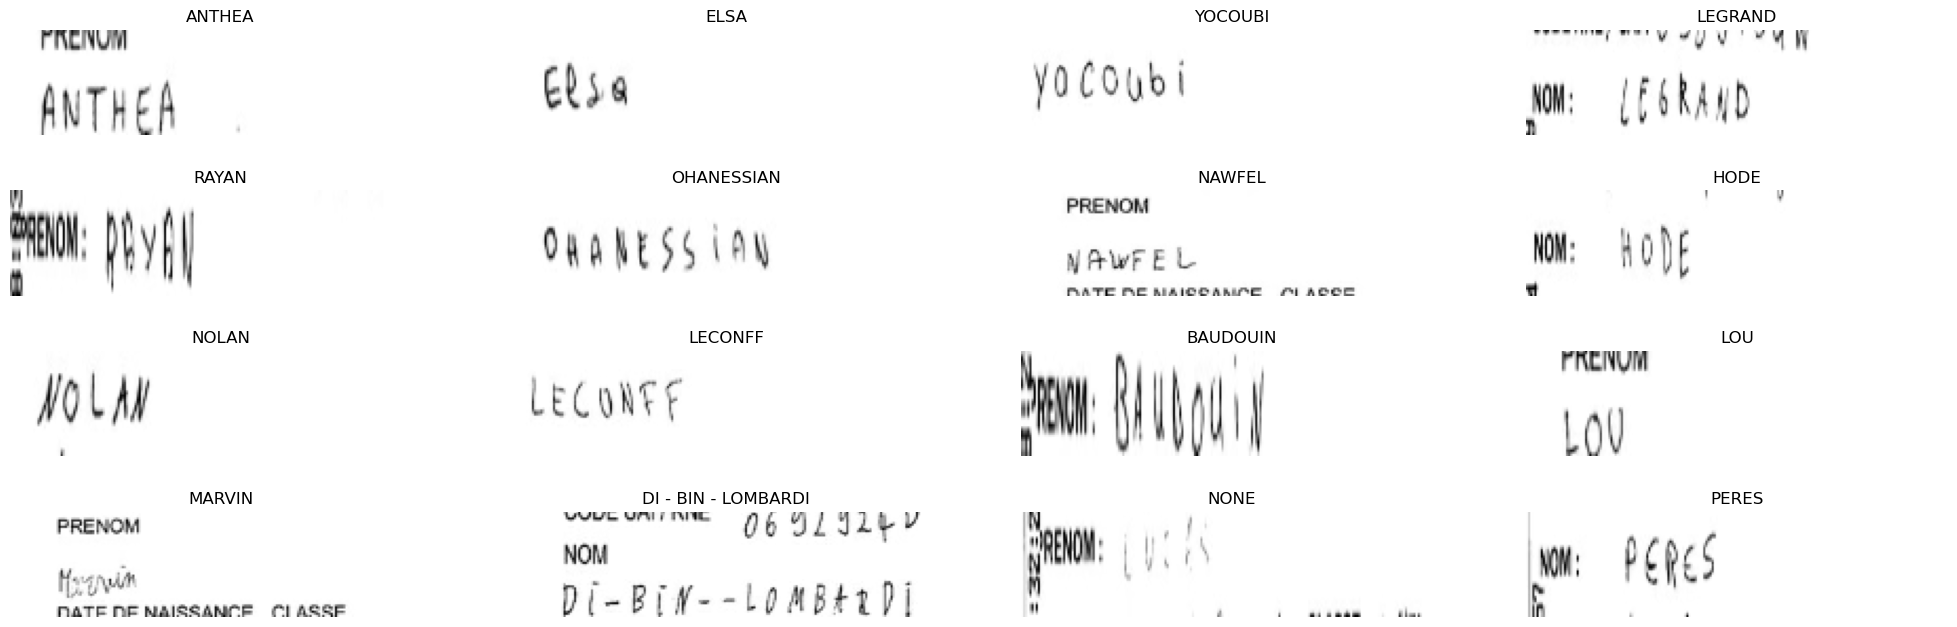

In [16]:
show_images(data=train_ds, cmap='gray')

The **CTC Loss/Layer** is a **crucial component** in an ***OCR model*** as it helps to calculate the **probability distribution** of different characters in an **input image sequence**, and enables the model to **recognize text** in challenging and ***variable handwriting styles.

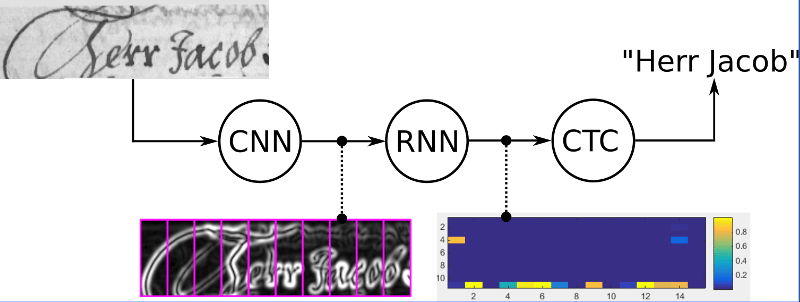

**CTC (Connectionist Temporal Classification) loss** is a loss function used in **deep learning models** for **sequence-to-sequence tasks** such as ***speech recognition, handwriting recognition, and text recognition***. The **CTC loss** is used to compute the **difference between the predicted output and the ground truth label**.

In the context of ***handwriting recognition***, the **CTC loss** takes in the **predicted sequence of characters** (in the form of **probability distribution** over the characters) and the **actual ground truth label** (which is a sequence of characters) and computes the difference between them. Since the length of the **predicted sequence** can be different from the **length of the ground truth label**, the **CTC loss** is used to align the **two sequences** by adding **blank characters** between the characters of the **predicted sequence**. This ensures that the length of the **predicted sequence matches the length of the ground truth label**.

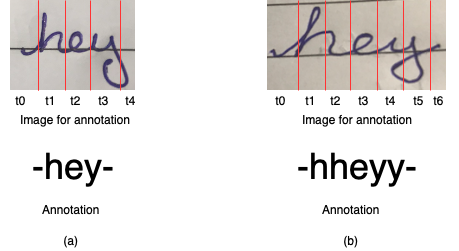

The **CTC loss** is calculated by **summing over all possible alignments** between the **predicted sequence** and the **ground truth label**. This is done by **dynamic programming**, which finds the most likely path through the **probability distribution of characters**. The **CTC loss function** then computes the **negative log probability** of the correct alignment. The goal of the **CTC loss** is to **minimize the difference between the predicted sequence and the ground truth label**.

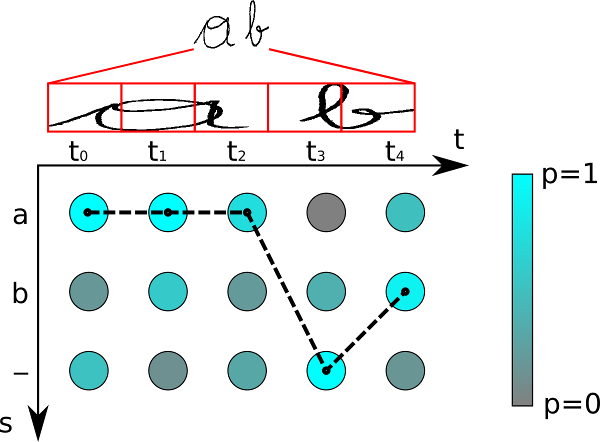

In summary, the **CTC loss** is used in ***sequence-to-sequence tasks*** to align the **predicted sequence and the ground truth label** by adding ***blank characters*** between the characters of the predicted sequence. The **CTC loss** is calculated by **dynamic programming**, and its goal is to ***minimize the difference between the predicted sequence and the ground truth label***.

In [17]:
class CTCLayer(layers.Layer):
    
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        
        self.add_loss(loss)
        
        return y_pred

# **OCR Model**

The ***optical character recognition (OCR)*** model is a powerful combination of ***convolutional neural networks (CNNs)*** and ***recurrent neural networks (RNNs)***. The **CNNs** are used to extract **high-level features** from the input images, while the ***RNNs*** are used to **generate the corresponding text output**.

These **two types of neural networks** are combined in a **transformer-like architecture**, which can be thought of as an ***Encoder-Decoder architecture***. In this architecture, the ***CNN*** serves as the ***Encoder***, which encodes the **image features** into an **encoding space**. The ***RNN*** then acts as the ***Decoder***, which uses this **encoding space** to generate the **corresponding text output**.

The use of this architecture allows the model to handle the **challenging task of recognizing handwritten text**, which is **often messy and difficult to read**. By leveraging both the **spatial information** from the ***CNNs*** and the **temporal information** from the ***RNNs***, the OCR model can **accurately recognize even the most complex handwritten text**.

Furthermore, to train the **OCR model**, a **loss function** called the ***Connectionist Temporal Classification (CTC) loss*** is used. This loss function allows the model to learn how to align the **predicted text output with the actual text output**, even in cases where there may be **missing or extra characters** in the input image. Overall, the OCR model is a powerful and effective tool for recognizing text in a wide variety of settings.

In [18]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model 
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

In [19]:
# Model Summary
ocr_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 100, 25, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 25, 64)  18496       ['max_pooling2d[0][0]']      

**Model Visualization**

---

To gain a better understanding of the **OCR model architecture**, let's take a visual look at it. As we can see, the model is a combination of an ***encoder-decoder architecture*** and a **CTC layer** addition for training purposes. The **encoder side** of the model is comprised of a ***convolutional neural network*** that encodes the **image features into an encoding space**, while the **decoder side** is made up of a ***recurrent neural network*** that **decodes the text from the encoding space**. The **CTC layer** serves as the **connection** between the **encoder and decoder**, allowing the model to **learn and predict the sequence of characters in the text**. By visualizing the model architecture, we can better understand how it operates and how it is able to accurately recognize text from handwritten images.

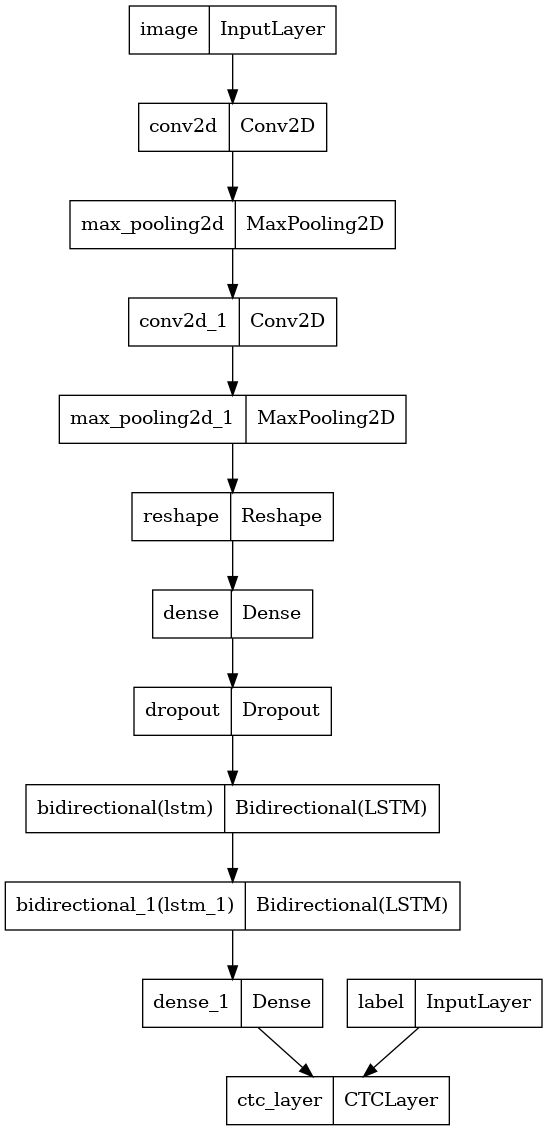

In [20]:
tf.keras.utils.plot_model(ocr_model)

Our model architecture is ready. It's time to train the model.

In [21]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/40
1000/1000 [==============================] - 50s 36ms/step - loss: 20.5292 - val_loss: 19.3276
Epoch 2/40
1000/1000 [==============================] - 32s 32ms/step - loss: 18.9716 - val_loss: 19.0082
Epoch 3/40
1000/1000 [==============================] - 32s 32ms/step - loss: 18.5502 - val_loss: 18.4155
Epoch 4/40
1000/1000 [==============================] - 31s 31ms/step - loss: 17.8401 - val_loss: 16.6801
Epoch 5/40
1000/1000 [==============================] - 31s 31ms/step - loss: 15.7440 - val_loss: 13.8241
Epoch 6/40
1000/1000 [==============================] - 31s 31ms/step - loss: 13.0640 - val_loss: 11.2453
Epoch 7/40
1000/1000 [==============================] - 31s 31ms/step - loss: 10.9386 - val_loss: 9.5814
Epoch 8/40
1000/1000 [==============================] - 31s 31ms/step - loss: 9.6292 - val_loss: 8.5664
Epoch 9/40
1000/1000 [==============================] - 30s 30ms/step - loss: 8.6841 - val_loss: 7.7285
Epoch 10/40
1000/1000 [============================

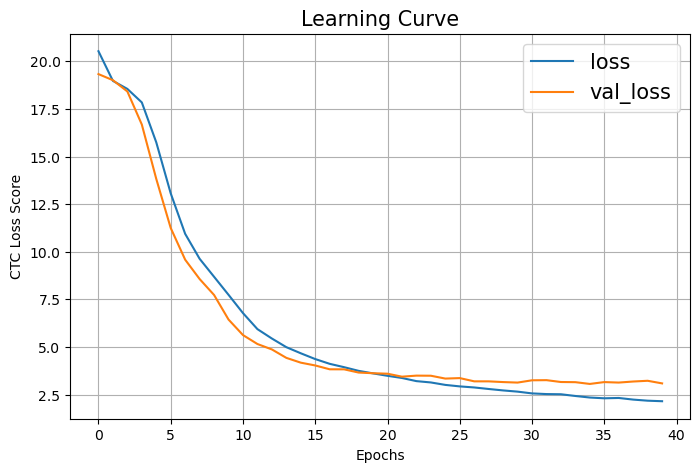

In [22]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve.png")
plt.show()

This is what we call a **nearly perfect training curve**. While it may appear that the **training loss diverges towards the end**, the **divergence is not significant**. Both the **training and validation loss continuously decrease**, which is a **positive sign**. This indicates that our model is able to understand the task well and is **learning to generalize well to new data**.

# **OCR Model Predictions**

In order to use our trained model for **making predictions**, we need to first **remove the CTC layer** from the model. This layer was added for **training purposes only** and is **not required for making predictions**. Once we have removed this layer, we can use the remaining ***encoder-decoder network*** for prediction.

However, the **output of this network** will be a **series of numeric values**, which represent the **probabilities of each character** being present in the image. To convert these **numeric values** into the **actual characters or categorical values**, we need a ***decoding function***.

This **decoding function** takes the **output of the model** and decodes it into the **final predicted text**. There are **different decoding strategies** that can be used, such as ***greedy decoding*** or ***beam search decoding***. The specific strategy used will depend on the requirements of the task and the characteristics of the data.

Once we have the **decoding function**, we can use it to convert the **model's output into the final predicted text**, which can then be compared to the **ground truth labels** to evaluate the **performance of the model**.

In [23]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense_1').output
)

# Model summary
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 200, 50, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 25, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 12, 64)       0         
 2D)                                                             
                                                                 
 reshape (Reshape)           (None, 50, 768)           0   

Now, as we have the inference model, let's focus on the **decoding function**

---
The **predictions generated** by the **OCR model** are in the form of a **matrix** where each **time step** represents the **probabilities for each character**. This means that for each **time step**, the model calculates the **likelihood of the output character being a certain character**.

The resulting **matrix** can be **quite complex** and may be **difficult to interpret at first glance**. However, if you have studied the ***Connectionist Temporal Classification (CTC)*** algorithm, this representation will be **easier to understand**. The **CTC algorithm** is a technique used to train the model to make predictions on sequences of variable length, which is often used in **speech and handwriting recognition tasks**.

In [24]:
def decode_pred(pred_label):
    
    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability 
    for each character. The function uses CTC decoding to decode the numeric labels back into their 
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.
    
    Argument : 
        pred_label : These are the model predictions which are needed to be decoded.
        
    Return:
        filtered_text : This is the list of all the decoded and processed predictions.
    
    '''
    
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

Let's see this function working.

In [25]:
print(decode_pred(inference_model.predict(test_ds)))

/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


100/100 [==============================] - 3s 17ms/step
['KEVIN', 'LOTE', 'LENA', 'JULES', 'CHERPIN', 'MARTIN', 'VALENTINE', 'LORAS', 'THIBAULT', 'ASAOI', 'GORICHAOF', 'MAHENTHIRAN', 'FRANCOSSSIICRA', 'JEANNE', 'DEBOAAH', 'PROUES', 'JOAL', 'CORNIL- FRERROT', 'CLEMENT', 'AELIS', 'NAHIZATA FATIN', 'FOURNEL', 'DICINTZOIILLESCA', 'BARSOT', 'DUVAL', 'ANTOAY', 'LISA', 'CELIA', 'GRODIAS', 'HUGO', 'HUGO', 'ELOUEN', 'SCHOCMAECHER', 'MORRAU', 'STEEVKERITE', 'DI FONIC', 'GUIREY', 'ROMAN', 'MILLE', 'CAROLINE', 'PAUL', 'BELHARA', 'DIBOS', 'JEAN CONE', 'DREPIN', 'CLOVIS', 'JORIS', 'MARUINI', 'CLAIRE', 'RAFFORT', 'ICHOROTS', 'DEBUYSSCHER', 'ALEXANDRE', 'RAPHAEL', 'KHIREPRINE', 'UMUT', 'GOUKAUD', 'ROMAN', 'LEDERMANN', 'JOSBIER', 'MAROY', 'ALEXANDRE', 'BOULANGER', 'MARNANE', 'PARIS', 'MELANIE', 'NOUASE', 'LEVRIT', 'PARENT', 'DEZCHENES', 'MAHAULT', 'DAGOAG', 'DUCHAINE', 'AYGUL', 'KARIN', 'ALEXIO', 'ESEA', 'BERUCUET', 'KEVIN', 'ZAMBRIHI', 'ALESSI', 'CHARLES', 'ELIA', 'ALEXANDRE', 'ROY- - COUTELLIER', 'LE

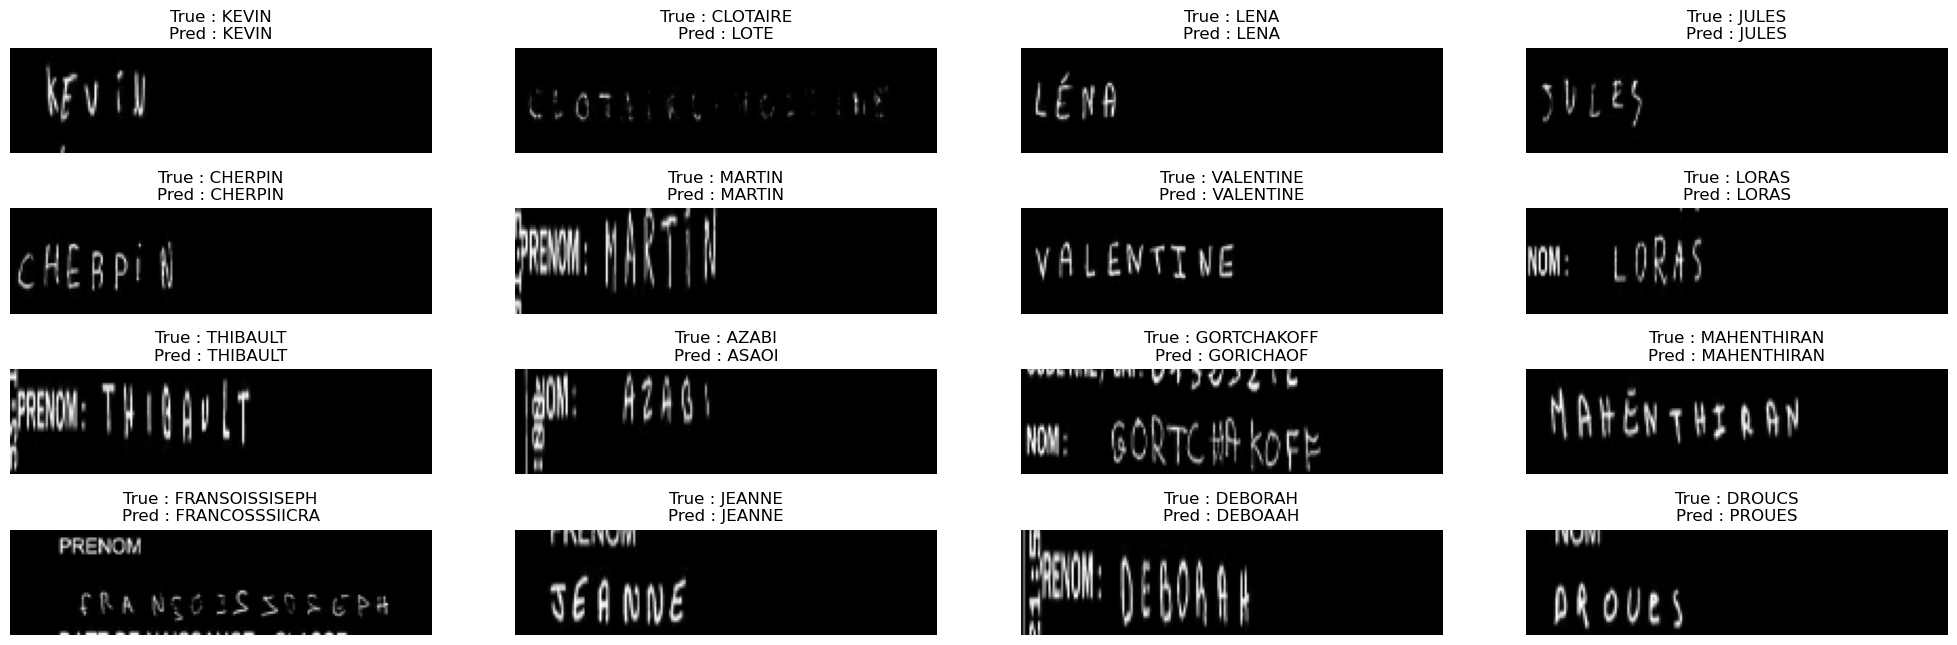

In [26]:
show_images(data=test_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

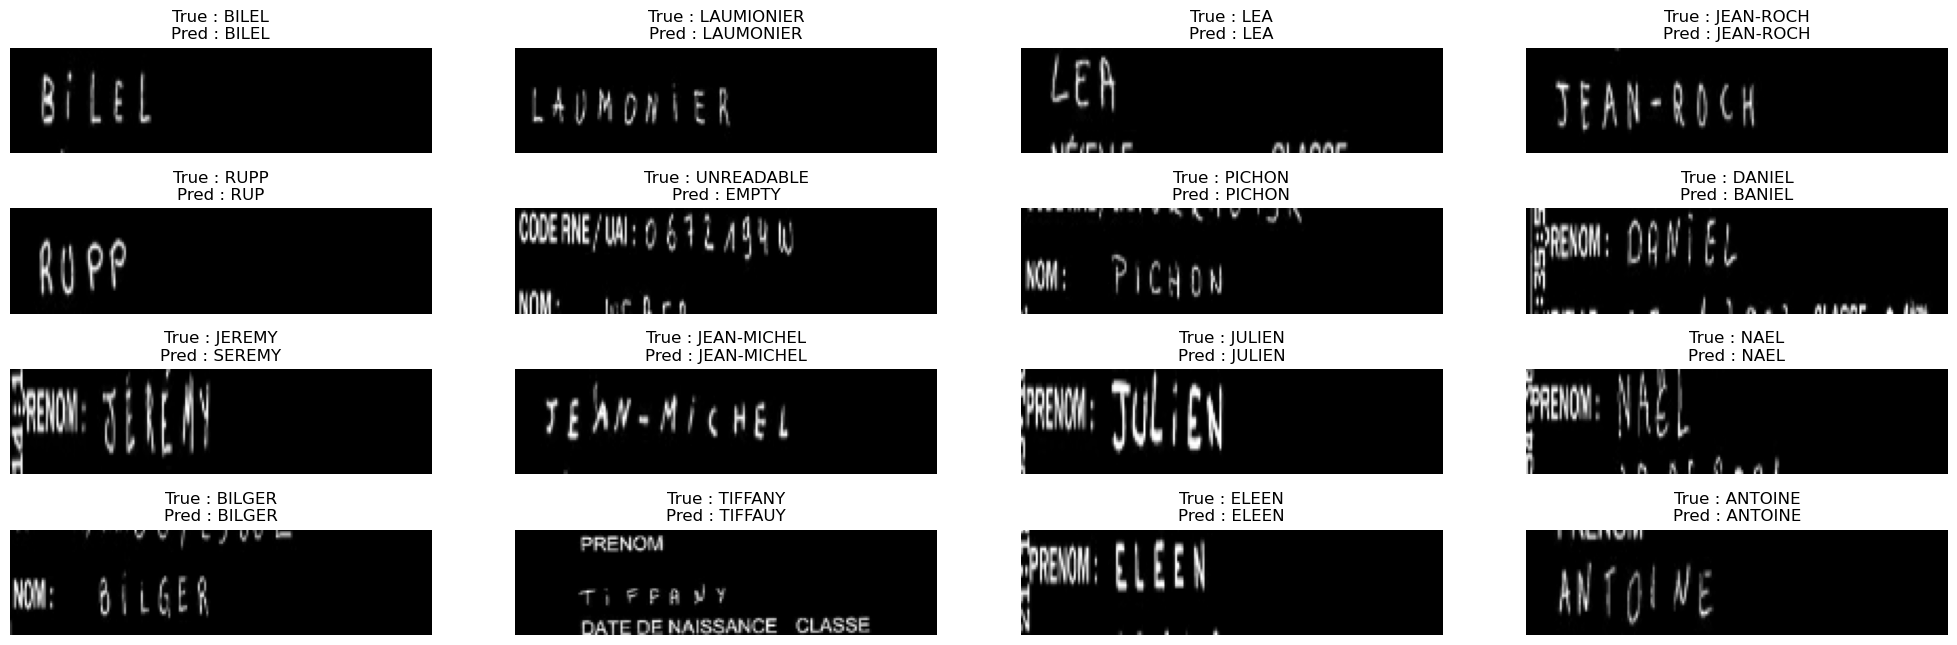

In [27]:
show_images(data=valid_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

# **OCR Model - Improved**

Epoch 1/40
1000/1000 [==============================] - 46s 37ms/step - loss: 20.4794 - val_loss: 19.7907
Epoch 2/40
1000/1000 [==============================] - 34s 34ms/step - loss: 19.0429 - val_loss: 19.2985
Epoch 3/40
1000/1000 [==============================] - 35s 35ms/step - loss: 18.4450 - val_loss: 18.3685
Epoch 4/40
1000/1000 [==============================] - 35s 35ms/step - loss: 18.2465 - val_loss: 18.1910
Epoch 5/40
1000/1000 [==============================] - 35s 35ms/step - loss: 18.0438 - val_loss: 17.8739
Epoch 6/40
1000/1000 [==============================] - 35s 35ms/step - loss: 17.5697 - val_loss: 17.3202
Epoch 7/40
1000/1000 [==============================] - 35s 35ms/step - loss: 16.7033 - val_loss: 15.4519
Epoch 8/40
1000/1000 [==============================] - 35s 35ms/step - loss: 14.1269 - val_loss: 12.3637
Epoch 9/40
1000/1000 [==============================] - 35s 35ms/step - loss: 10.5554 - val_loss: 7.2105
Epoch 10/40
1000/1000 [========================

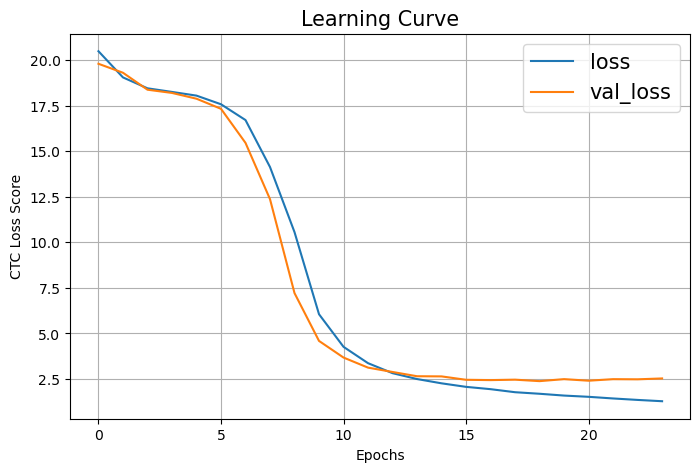

In [28]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.Conv2D(
    filters=128, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.4)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model 
ocr_model_2 = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

# Compile
ocr_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Train
history_2 = ocr_model_2.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Learning Curve
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
# plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [29]:
# Model required for inference
inference_model_2 = keras.Model(
    inputs=ocr_model_2.get_layer(name="image").input,
    outputs=ocr_model_2.get_layer(name='dense_4').output
)

# Model summary
inference_model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 50, 32)       320       
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 50, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 25, 32)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 25, 64)       18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 25, 128)      73856     
                                                           

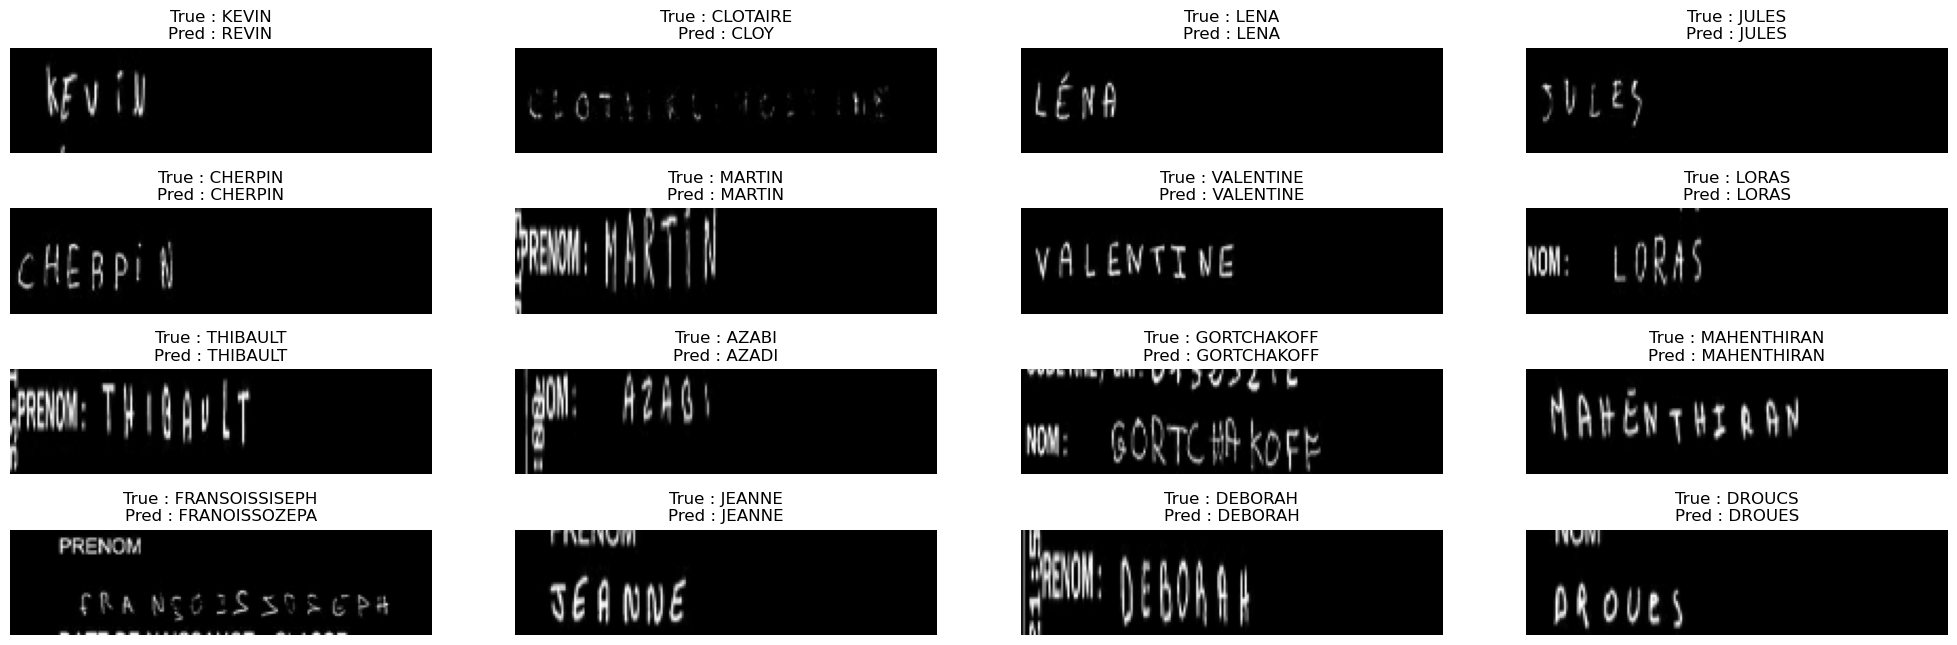

In [30]:
show_images(data=test_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

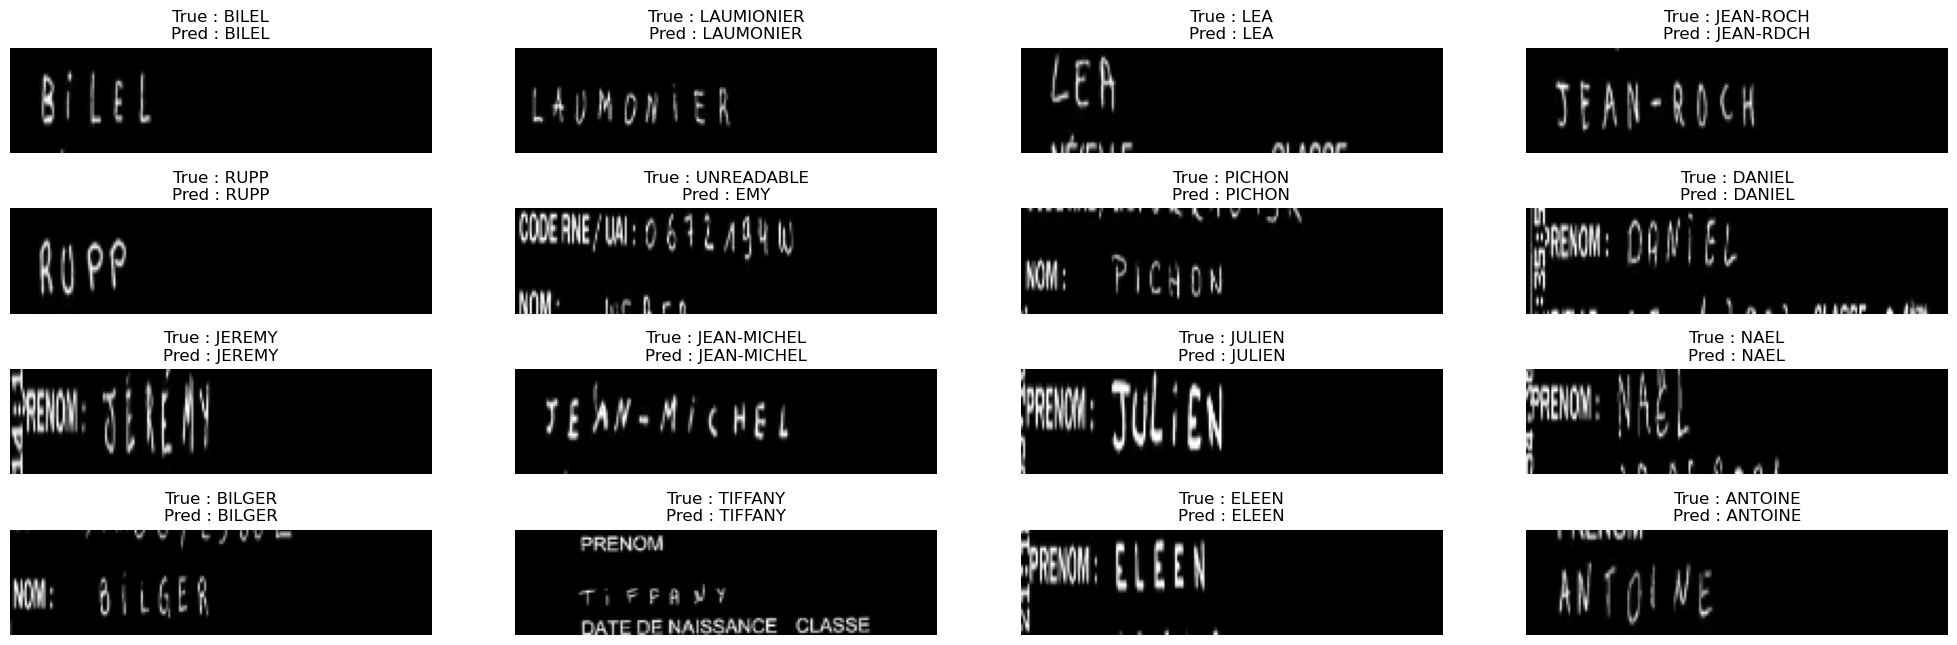

In [31]:
show_images(data=valid_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')